# OWCsim-Py: CIR

authors: ardimasp

In [1]:
# Print timestamp
import datetime
now = datetime.datetime.now()

print("date:{}".format(now))

## Introduction

`OWCsim-Py v0.0.1` supports deterministic methods to calculate the CIR with frequency and time-domain approach. 

The frequency-domain approach is mainly based on:
<br>
[H. Schulze, "Frequency-Domain Simulation of the Indoor Wireless Optical Communication Channel," in IEEE Transactions on Communications, vol. 64, no. 6, pp. 2551-2562, June 2016.](https://ieeexplore.ieee.org/document/7457357)
<br>
The advantage of this method is that it can consider infinite number of reflections. The disadvantage is that the calculation involves an inversion of a big matrix ($N\times N$, where $N$ is the number of reflectors).

The time-domain approach is mainly based on:
<br>
[J. B. Carruthers and P. Kannan, "Iterative site-based modeling for wireless infrared channels," in IEEE Transactions on Antennas and Propagation, vol. 50, no. 5, pp. 759-765, May 2002.](https://ieeexplore.ieee.org/document/1011244)
<br>
The advantage is that the method is iterative (or recursive if it is based on the conventional method). So, there is no need to the inversion on a big matrix. The main disadvantage is that it is more suitable for finite number of reflections.




## Libraries

In [2]:
%matplotlib notebook

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.constants import speed_of_light

from owcsimpy.geoobjects.models.roomcube_py import RoomCube_py as Room
from owcsimpy.geoobjects.models.humancubes_py import HumanCubes_py as Human
from owcsimpy.geoobjects.models.pointsource_py import PointSource_py as PointSource
from owcsimpy.geoobjects.models.baredetector_py import BareDetector_py as BareDetector
from owcsimpy.geoutils.draw import draw
from owcsimpy.cir.freqdomaincir import FreqDomainCIR
from owcsimpy.cir.timedomaincir import TimeDomainCIR

## Setup

<IPython.core.display.Javascript object>


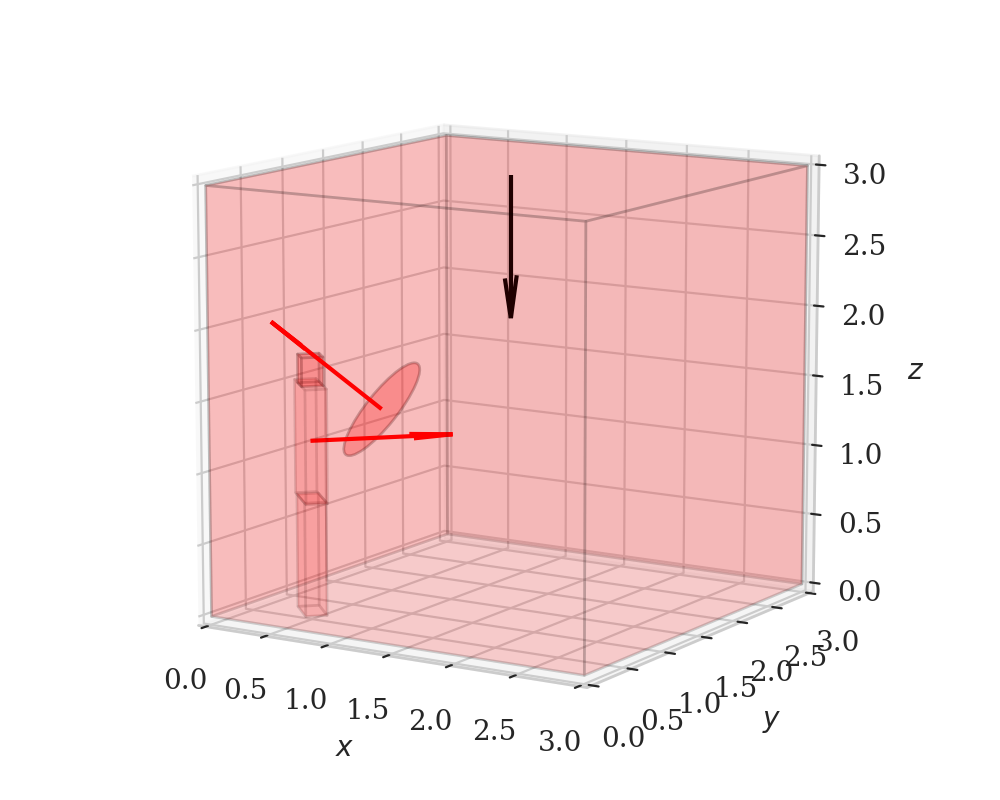

In [4]:
timeSampling=1e-9

# Room
rho_keys = ['b','t','s','n','e','w']
rho_vals = [0.2,0.5,0.5,0.5,0.5,0.5]
reflectivities = {rho_keys[i]:rho_vals[i] for i in range(6)}

room = Room(dimensions=[3,3,3],identity=1,reflectivities=reflectivities)

# Person
rho_keys = ['hair','face','shirt']
rho_vals = [0.6,0.5,0.3]
reflectivities = {rho_keys[i]:rho_vals[i] for i in range(len(rho_keys))}

persons = []
persons.append(Human(
    direction=np.deg2rad(45),
    loc=np.array([0.5,0.5]),
    reflectivities=reflectivities))

# LED
led = PointSource(np.pi,0,np.array([1.5,1.5,3]))

# PD
polar = np.deg2rad(50)
azimuth = persons[0].listPlanes[1]._RectPlane_py__normalVect.spherical[2]+np.pi
loc = (persons[0].ctrPoint
       +0.5*persons[0].listPlanes[1].normalVect
       +np.array([0,0,0.2]))
pd = BareDetector(polar,azimuth,loc,area=1e-4)

fig,ax = draw(xlim=[0,3],ylim=[0,3],zlim=[0,3],
              figsize=(5,4),azim=-58,elev=11)

fig,ax = draw(figure=fig,axes=ax,models3d=[room],lengths=1e-5)
fig,ax = draw(figure=fig,axes=ax,models3d=[persons[0]],lengths=0.5)
fig,ax = draw(figure=fig,axes=ax,vectors=led,colors='black')
fig,ax = draw(figure=fig,axes=ax,circles=pd,scales=5e3)

## Freq. Domain 

In [5]:
%%time 

fdcir = FreqDomainCIR(N=2**10,freqSampling=1/timeSampling)
Hf_los_fd, Hf_diff_fd = fdcir.calc(led,pd,persons,room,
                                  partitionDist=speed_of_light*timeSampling)

# Transform to time-domain
ht_los_fd, ht_diff_fd = fdcir.transform(window='None')


CPU times: user 3min 48s, sys: 8.82 s, total: 3min 57s
Wall time: 1min 5s


## Time Domain

In [6]:
%%time

tdcir = TimeDomainCIR(timeSampling=0.5e-9)
ht_los_td, ht_diff_td = tdcir.calc(led,pd,persons,room,
                                   numReflections=10,partitionDist=speed_of_light*0.5e-9)

# Transform to freq-domain
Hf_los_td, Hf_diff_td = tdcir.transform()

CPU times: user 39.8 s, sys: 101 ms, total: 39.9 s
Wall time: 39.9 s


In [7]:
%%time

tdcir2 = TimeDomainCIR(timeSampling=0.5e-9)
ht_los_td2, ht_diff_td2 = tdcir2.calc(led,pd,persons,room,
                                      numReflections=3,partitionDist=speed_of_light*0.5e-9)

# Transform to freq-domain
Hf_los_td2, Hf_diff_td2 = tdcir2.transform()

CPU times: user 8.09 s, sys: 20.5 ms, total: 8.11 s
Wall time: 8.11 s


## Plot

<IPython.core.display.Javascript object>


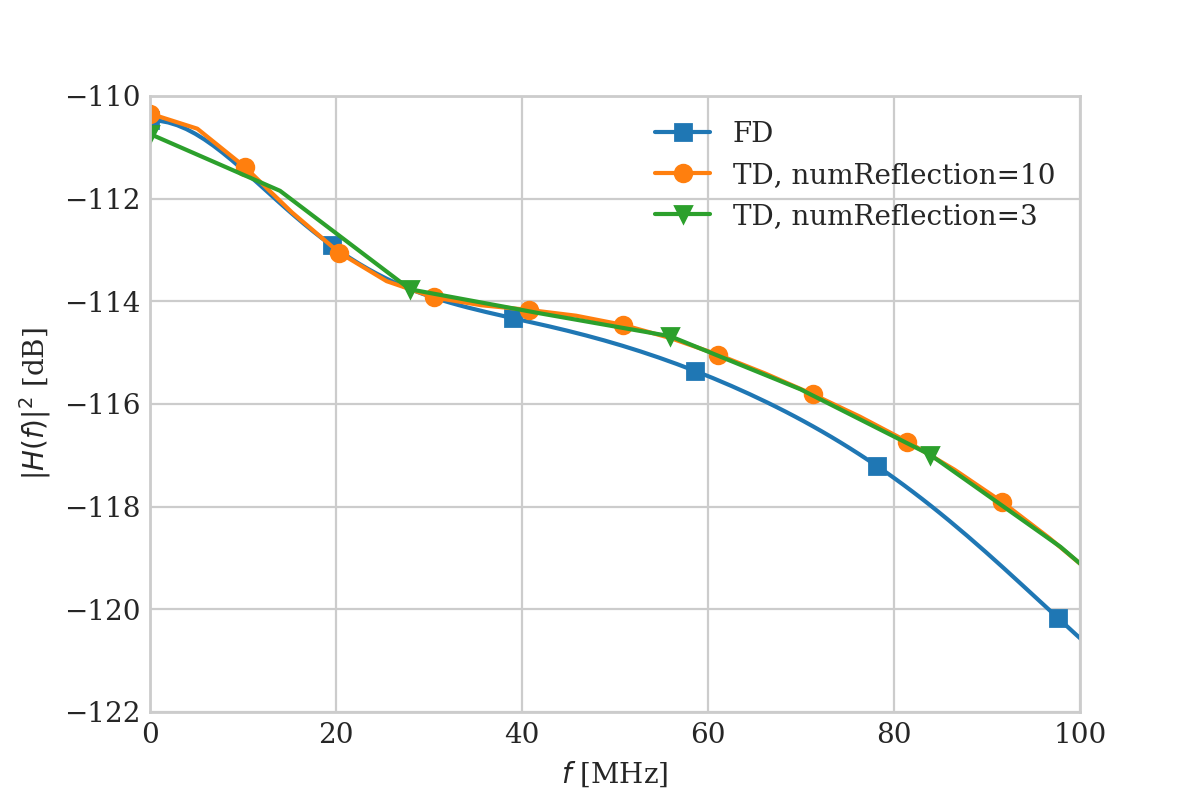

In [8]:
# Freq. response
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(fdcir.f/1e6,10*np.log10(np.abs(Hf_los_fd+Hf_diff_fd)**2),label='FD',marker="s",markevery=20)
ax.plot(tdcir.f/1e6,10*np.log10(np.abs(Hf_los_td+Hf_diff_td)**2),label='TD, numReflection=10',marker="o",markevery=2)
ax.plot(tdcir2.f/1e6,10*np.log10(np.abs(Hf_los_td2+Hf_diff_td2)**2),label='TD, numReflection=3',marker="v",markevery=2)
ax.set_xlim([0,100])
ax.set_ylim([-122,-110])
ax.set_xlabel(r"$f$ [MHz]"); 
ax.set_ylabel(r"$\vert H(f) \vert^2$ [dB]");
ax.legend();


<IPython.core.display.Javascript object>


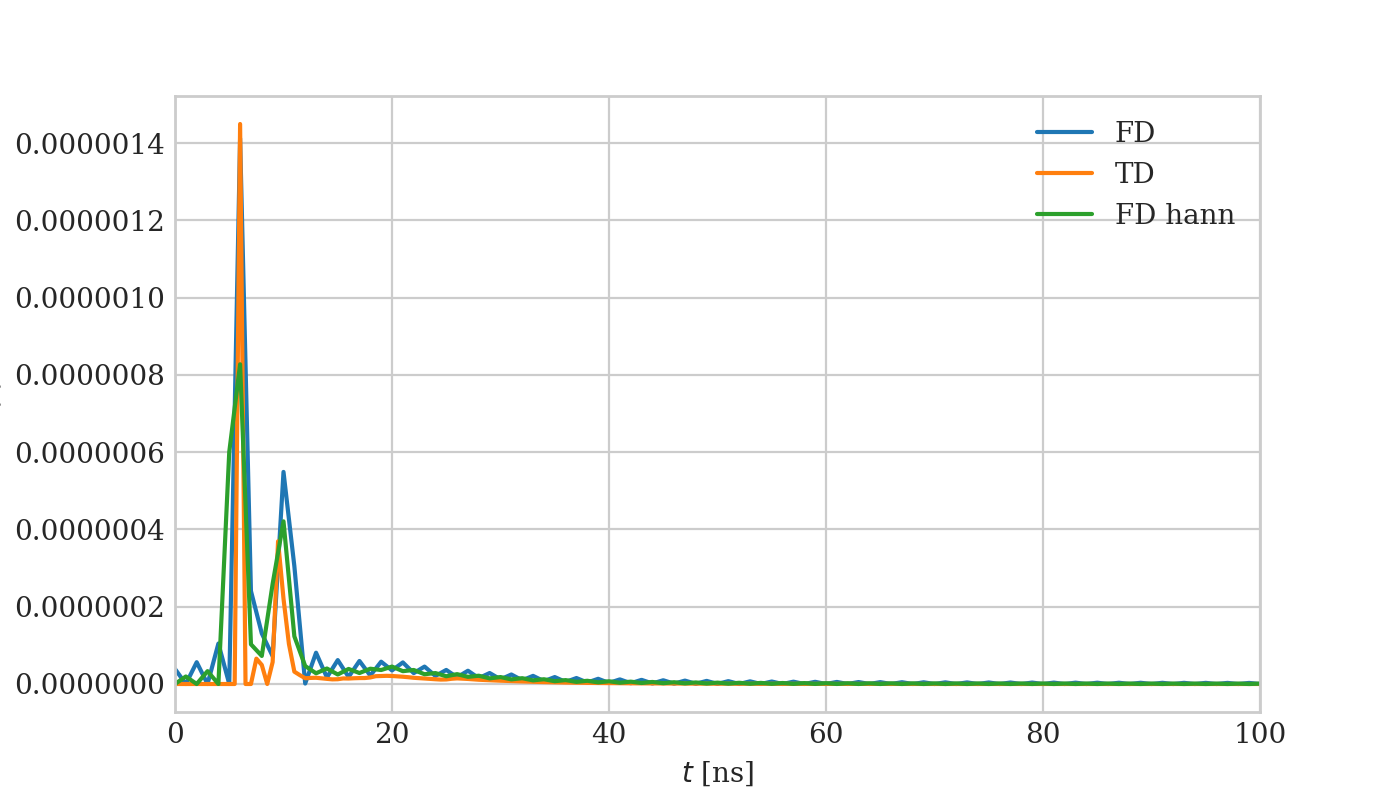

In [9]:
# CIR

fig, ax = plt.subplots(figsize=(7,4))

ax.plot(fdcir.t*1e9,(ht_los_fd+ht_diff_fd),label='FD')
ax.plot(tdcir.t*1e9,(ht_los_td+ht_diff_td),label='TD')

ht_los_fd_hann, ht_diff_fd_hann = fdcir.transform(window='hann',L=6)
ax.plot(fdcir.t[0:len(fdcir.t)-2]*1e9,(ht_los_fd_hann[2:]+ht_diff_fd_hann[2:]),label='FD hann')

ax.set_xlim([0,100])
ax.set_xlabel(r"$t$ [ns]"); ax.set_ylabel(r"$h(t)$");
ax.legend();

## Conclusions

1. Freq. domain approach has the downside on converting it to TD. The main reason is due to the inaccuracy in determining the time bins in doing IFFT. Hence, a filtering window is required. 
2. Time domain approach needs lower time resolution and more number of reflections to sufficiently approach FD's result.